In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('STB.csv')
#df1=df.reset_index()['Price']
df=df.reset_index()['Price']
df

0       11750
1       12550
2       12900
3       13300
4       13000
        ...  
1237    27000
1238    27400
1239    27000
1240    27200
1241    27850
Name: Price, Length: 1242, dtype: int64

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


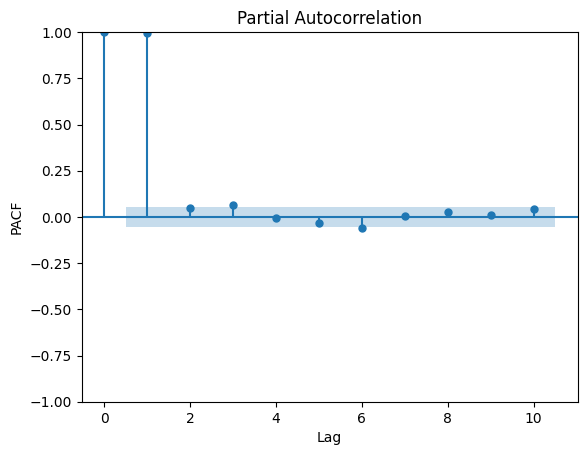

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Dữ liệu chuỗi thời gian
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Vẽ đồ thị PACF
plot_pacf(df, lags=10)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
10/10 [==============================] - 12s 258ms/step - loss: 0.0186 - val_loss: 0.4259
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.0098 - val_loss: 0.3623
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.2848
Epoch 4/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.2498
Epoch 5/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.2745
Epoch 6/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.2845
Epoch 7/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.2746
Epoch 8/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.2629
Epoch 9/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.2603
Epoch 10/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.2546
Epoch 1

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


8/8 [==============================] - 0s 4ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)


In [13]:
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [14]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 5199.642001194014
Testing RMSE: 9286.291756143064
Validation MAPE: 19.969518826218806
Testing MAPE: 32.79397578856602
Validation MAE: 4175.223635924645
Testing MAE: 7539.324615533502


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[len(val_data)-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
lst_output=scaler.inverse_transform(lst_output)
print(lst_output)

[0.8158288]
2
1 day input [0.8158288]
1 day output [[0.93890893]]
2 day input [0.93890893]
2 day output [[1.0957366]]
3 day input [1.09573662]
3 day output [[1.2901975]]
4 day input [1.29019749]
4 day output [[1.5170239]]
5 day input [1.51702392]
5 day output [[1.7554433]]
6 day input [1.75544333]
6 day output [[1.9728866]]
7 day input [1.97288656]
7 day output [[2.142631]]
8 day input [2.14263105]
8 day output [[2.258008]]
9 day input [2.258008]
9 day output [[2.3287485]]
10 day input [2.32874846]
10 day output [[2.3693073]]
11 day input [2.36930728]
11 day output [[2.391652]]
12 day input [2.39165211]
12 day output [[2.4036891]]
13 day input [2.40368915]
13 day output [[2.4100943]]
14 day input [2.41009426]
14 day output [[2.4134808]]
15 day input [2.41348076]
15 day output [[2.4152648]]
16 day input [2.41526484]
16 day output [[2.416203]]
17 day input [2.41620302]
17 day output [[2.4166958]]
18 day input [2.41669583]
18 day output [[2.4169548]]
19 day input [2.41695476]
19 day outpu

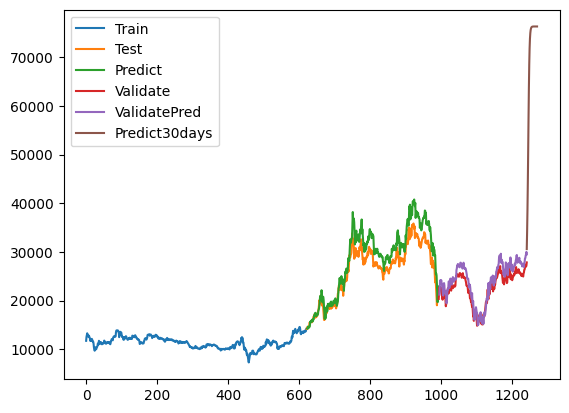

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,lst_output)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()